# 13.4 Dead ReLU Problem与学习率优化

和Sigmoid，tanh激活函数不同，Relu激活函数的叠加并不会出现梯度消失或者梯度爆炸，但Relu激活函数中使得部分数值归零的特性却会导致另一个严重的问题——Dead Relu probelem，也被称为神经元活性失效问题。

## 13.4.1 Dead Relu problem成因分析

## 13.4.1.1 Dead Relu problem直接表现

首先我们通过实验来观察神经元活性失效问题（Dead Relu problem）在建模过程中的直接表现。其实在上一节中，最后出现的Relu叠加模型在迭代多次后在MSE取值高位收敛的情况，其实就是出现了神经元活性失效所导致的问题。

In [1]:
# 随机模块
import random

# 绘图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# numpy
import numpy as np

# pytorch
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchLearning import *

from torch.utils.tensorboard import SummaryWriter

# 一个cell输出多个结果
writer = SummaryWriter(log_dir= 'reg_loss')


In [2]:
# 设置随机数种子
torch.manual_seed(420)

# 创建最高项为2的多项式回归数据集
features, labels = tensorGenReg(w= [2, -1], bias= False, deg= 2)

# 进行数据集切分于加载
train_loader, test_loader = split_loader(features, labels)

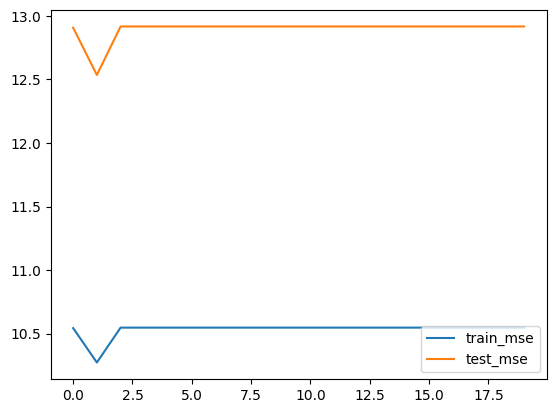

In [3]:
# 创建随机数种子
torch.manual_seed(420)

# 实例化模型
relu_model3 = Relu_class3(bias= False)      #  为了更方便的观察神经元活性失效问题，我们创建不带截距的模型

# 核心参数
num_epochs = 20
lr = 0.03

# 模型训练
train_1, test_1 = model_train_test(relu_model3,
                                   train_loader,
                                   test_loader,
                                   num_epochs= num_epochs,
                                   criterion= nn.MSELoss(),
                                   optimizer= optim.SGD,
                                   lr= 0.03,
                                   cla= False,
                                   eva= mse_cal)

# 绘制图像，查看MSE变化情况
plt.plot(list(range(num_epochs)), train_1, label = 'train_mse')
plt.plot(list(range(num_epochs)), test_1, label = 'test_mse')
plt.legend(loc = 4)

我们发现，模型在迭代多轮之后，训练误差和测试误差都在各自取值的高位收敛了，也就是误差不随模型迭代测试增加而递减。通过简单尝试我们不难发现，此时模型对所有的输出结果都是0.

In [4]:
relu_model3(features)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

### 13.4.1.2 Dead Relu Probelem基本判别

神经元活性失效问题和Relu激活函数本身特性有关。首先，我们观察激活函数图像与导函数图像。

In [5]:
# 绘制Relu函数的函数图像和导函数图像
X = torch.arange(-5, 5, 0.1)
X.requires_grad = True
relu_y = torch.relu(X)

In [6]:
# 反向传播
relu_y.sum().backward()

Text(0.5, 1.0, 'Relu Derivative function')

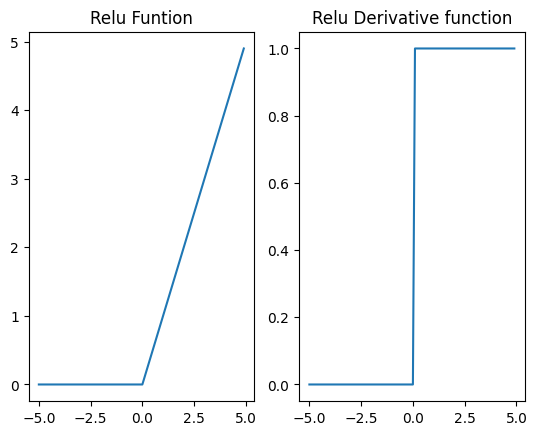

In [7]:
# Relu函数图像
plt.subplot(121)
plt.plot(X.detach(), relu_y.detach())
plt.title('Relu Funtion')

# Relu导函数图像
plt.subplot(122)
plt.plot(X.detach(), X.grad.detach())
plt.title('Relu Derivative function')

对于Relu激活函数来说，只要激活函数接收到的数据小于0,输出结果就全是0,并且更关键的是，只要Relu输出结果是0,由于Relu的导函数是分段常数函数且接收数据为负数时导函数全为0,因此如果Relu输出结果为0,则反向传播结果，也就是各层的梯度，也都是为0。

我们进一步通过举例说明，现有模型基本结构如下：

![Alt text](image-50.png)

设 W1 为第一层传播的权重， W2 为第二层传播的权重，并且 W1 的第一列对应连接隐藏层第一个神经元的权重，W1的第二列对应连接隐藏层第二个神经元的权重，f为输入的特征张量，并且只有一条数据

In [8]:
w1 = torch.tensor([[0., 0], [-1, -2]], dtype= torch.float32, requires_grad= True)
w1

tensor([[ 0.,  0.],
        [-1., -2.]], requires_grad=True)

In [9]:
w2 = torch.tensor([1., -1]).reshape(-1, 1)
w2.requires_grad = True

In [10]:
f = torch.tensor([[1, 2.]])
f.shape

torch.Size([1, 2])

第一次向前传播过程如下：

In [11]:
# 线性变换
f2 = torch.mm(f, w1)
f2

tensor([[-2., -4.]], grad_fn=<MmBackward0>)

In [12]:
# 激活函数处理
f3 = torch.relu(f2)
f3

tensor([[0., 0.]], grad_fn=<ReluBackward0>)

In [13]:
# 输出结果
out = torch.mm(f3, w2)
out

tensor([[0.]], grad_fn=<MmBackward0>)

l为f的真实标签，则损失函数和反向传播过程如下：

In [14]:
l = torch.tensor([[3.]])
l

tensor([[3.]])

In [15]:
loss = F.mse_loss(out, l)

In [16]:
loss

tensor(9., grad_fn=<MseLossBackward0>)

In [17]:
loss.backward()

而此时 w1，W2的梯度如下：

In [18]:
w1.grad

tensor([[0., 0.],
        [0., 0.]])

In [19]:
w2.grad

tensor([[0.],
        [0.]])

我们发现，当某条数据在模型汇总的输出结果为0时，反向传播后各层参数的梯度也全为0,此时参数将无法通过迭代更新。而进一步的，如果在某种参数情况下，整个训练数据集之后输出的结果都是0,则在小批量梯度下降的情况下，每次再挑选出一些数据继续进行迭代，仍然无法改变输出结果是0的情况，此时参数无法得到更新，进而下次输入的小批数据结果还是0,从而梯度为0,从而参数无法更新...至此进入死循环，模型失效，激活函数失去活性，也就出现了Dead Relu Problem。

当然，上述过程可以由如下数学过程说明，假设模型预测值：

$$
\hat{y}=\operatorname{ReLU}\left(X * w_1\right) * w_2
$$

并且，出现Dead Relu Problem的时候，某一组w1恰好使得Relu输出结果为0,因此y^=0,此时损失函数为：

$$
\text { loss }=M S E=\frac{\sum\left((\hat{y}-y)^2\right)}{N}
$$

根据链式法则，此时梯度为：

$$
\begin{aligned}
\text { grad } & =\left(\frac{\partial l o s s}{\partial w_1}, \frac{\partial l o s s}{\partial w_2}\right) \\
& =\left(\frac{\partial l o s s}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial w_1}, \frac{\partial l o s s}{\partial \hat{y}} \frac{\partial \hat{y}}{\partial w_2}\right)
\end{aligned}
$$

由于 $ \hat{y} $ 恒为0（为一个常量），由 Relu激活函数导函数特性可知， $ \hat{y} $ 对任何自变量偏导也为0,此时grad也就为 0, w1, w2不会再更新。而参数不更新， $ \hat{y} $ 仍然为0,梯度还是为0,如此往复，就出现了上述死循环，也就是Dead Relu problem。

### 13.4.1.2 Dead Relu Probelem发生概率

当然，我们也可略微进行一些拓展，试想一下，出现Dead Relu Problem问题的概率，其实是伴随着Relu层的增加而增加的。如果是两层Relu层，模型结构如下：

![Alt text](image-53.png)

向前传播过程中，模型输出结果为：

$$
\hat{y}=\operatorname{ReLU}\left(\operatorname{ReLU}\left(X * w_1\right) * w_2\right) * w_3
$$

不难发现，在两层 Relu嵌套的情况下，$ \hat{y} $ 取值为0的概率就更大了，出现了Dead Relu Problem的概率也就越高了。而同时，根据各层参数的梯度计算公式我们也能够发现，只要其中任意一层输出结果是0,则所有层参数的梯度均为0。

$$
\begin{gathered}
\operatorname{grad}_1=\frac{\partial l o s s}{\partial \hat{y}} \cdot w_3 \cdot f\left(F\left(X * w_1\right) * w_2\right) \cdot w_2 \cdot f\left(X * w_1\right) \cdot X \\
\operatorname{grad}_2=\frac{\partial l o s s}{\partial \hat{y}} \cdot w_3 \cdot f\left(F\left(X * w_1\right) * w_2\right) \cdot F\left(X * w_1\right) \\
\operatorname{grad}_3=\frac{\partial l o s s}{\partial \hat{y}} \cdot F\left(F\left(X * w_1\right) * w_2\right)
\end{gathered}
$$

最终，我们可以通过如下表达式判别Relu 激活函数是否失效

In [20]:
train_loader.dataset[:][0]

tensor([[-1.4463, -0.6221],
        [-0.4742, -0.2939],
        [ 1.9870,  0.1949],
        ...,
        [-1.6366, -2.1399],
        [-1.8178, -1.4618],
        [ 0.2646,  2.3555]])

In [21]:
relu_model3(train_loader.dataset[:][0])

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      

In [22]:
(relu_model3(train_loader.dataset[:][0]) == 0).sum()

tensor(700)

## 13.4.2 通过调整学习率缓解 Dead Relu Problem

在所有的解决Dead Relu Problem的方法中，最简单的一种方法就是调整学习率。尽管我们知道，Relu叠加越多层越容易出现神经元活性失效，但我们可以简单通过降低学习率的方法来缓解神经元活性失效的问题，甚至可以说这是一种通用且有效的方法。

学习率作为模型重要的参数，会在各方面影响模型效果，此前我们曾介绍学习率越小，收敛速度就越慢，而学习率过大，则又容易跳过最小值点造成模型结果振荡。对于Relu激活函数来说，参数稍有不慎就容易落入输出值全为0的陷阱，因此训练过程需要更加保守，采用更小的学习率逐步迭代。当然学习率的减小必然需要增加迭代次数，但由于Relu激活函数计算过程相对简单，增加迭代次数不会显著增加计算量。

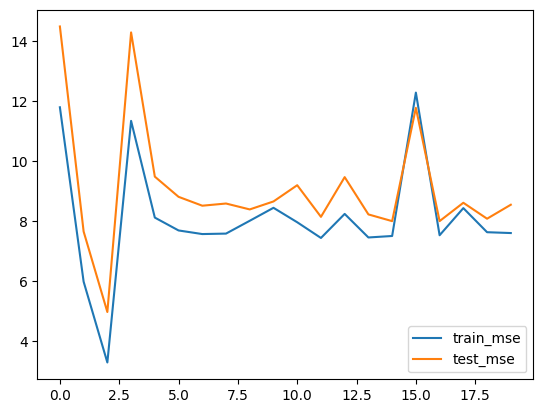

In [23]:
# 创建随机数种子
torch.manual_seed(420)

# 实例化模型
relu_model3 = Relu_class3()      #  为了更方便的观察神经元活性失效问题，我们创建不带截距的模型

# 核心参数
num_epochs = 20
lr = 0.03

# 模型训练
train_1, test_1 = model_train_test(relu_model3,
                                   train_loader,
                                   test_loader,
                                   num_epochs= num_epochs,
                                   criterion= nn.MSELoss(),
                                   optimizer= optim.SGD,
                                   lr= lr,
                                   cla= False,
                                   eva= mse_cal)

# 绘制图像，查看MSE变化情况
plt.plot(list(range(num_epochs)), train_1, label = 'train_mse')
plt.plot(list(range(num_epochs)), test_1, label = 'test_mse')
plt.legend(loc = 4)

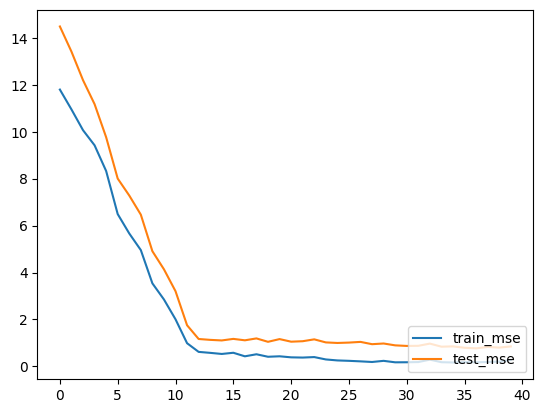

In [24]:
# 创建随机数种子
torch.manual_seed(420)

# 实例化模型
relu_model3 = Relu_class3()      #  为了更方便的观察神经元活性失效问题，我们创建不带截距的模型

# 核心参数
num_epochs = 40
lr = 0.001

# 模型训练
train_1, test_1 = model_train_test(relu_model3,
                                   train_loader,
                                   test_loader,
                                   num_epochs= num_epochs,
                                   criterion= nn.MSELoss(),
                                   optimizer= optim.SGD,
                                   lr= lr,
                                   cla= False,
                                   eva= mse_cal)

# 绘制图像，查看MSE变化情况
plt.plot(list(range(num_epochs)), train_1, label = 'train_mse')
plt.plot(list(range(num_epochs)), test_1, label = 'test_mse')
plt.legend(loc = 4)

我们发现学习率调整后，学习效果变得更好了

## 13.4.3 ReLU激活函数特效理解

至此，我们也可以进一步理解ReLU激活函数的实际作用。可以这么说，ReLU激活函数的实际作用是‘选择性更新部分参数’，回顾上述公式，我们不难发现，当激活函数都是ReLU激活函数时，以上述例子为例，无论是第一层接收到的数值（X * W1）小于0，还是第二层接收到的数值（F（X * W1）* W2）小于0，都会导致三层参数的梯度为0，同时，哪怕是第一层接收到的数据全是0，也会导致所有参数本轮不被更新。而在实际深度学习建模过程中，我们是采用小批量梯度下降算法来进行梯度计算，而如果某一批的数据输出结果为0，则当前迭代结束时参数不变，也就相当于模型采用了‘有选择’的数据进行参数更新————只选择了那些输出结果不为0的数据进行参数训练，同时我们需要知道的是，这一轮某一批数据没有被选择，不代表下一轮这批数据仍不被选择（因为参数会变化，因而输出结果也会发生变化），因此我们可以理解为每一轮都带入不同数据进行参数训练，从而最终完成模型训练。

并且，从梯度消失和梯度爆炸角度考虑，ReLU激活函数拥有更加优异的特性。我们都知道，ReLU激活函数的导函数取值要么是1要么是0，当导函数取值为1时，能够保证各层参数梯度再计算时不受因层数变化而累乘的导函数影响（因为导函数取值都为1）。

    值得注意的是，每次带入不同批次数据训练，或者说每次有选择性的忽略部分数据，就相当于进行了‘非线性’变换

    关于‘随机性’的作用，其实我们已经见过很多次了，在集成模型中，我们将在一定随机性条件下构建的、彼此不同的基分类器进行集成，从而创建一个效果明显好于单个基分类的集成模型；在SGD中，我们采用每次带入随机部分数据的方法进行梯度下降迭代，从而使得迭代过程能够跳出局部最小值点；而在ReLU激活函数中，我们随机挑选部分参数进行迭代，从而完成数据的‘非线性’转化，进而保证模型本身的有效性。

    也正因如此，ReLU激活函数也被称为非饱和激活函数

我们可以观察上一节模型训练结束后各层参数的梯度

In [25]:
# 观察各层梯度
for m in relu_model3.modules():
    if isinstance(m, nn.Linear):
        print(m.weight.grad)

tensor([[-7.3739, -2.6226],
        [-7.9173, -2.6964],
        [ 3.7016,  0.4324],
        [ 9.1712,  5.0160]])
tensor([[  0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000],
        [-10.6886,  -5.4182,  -1.6595, -15.9431],
        [  4.7269,   2.3813,   0.8299,   6.8923]])
tensor([[ 0.0000,  0.0000,  2.6702,  1.5113],
        [ 0.0000,  0.0000,  2.9438,  1.6662],
        [ 0.0000,  0.0000, -3.1529, -1.7845],
        [ 0.0000,  0.0000, -3.0916, -1.7498]])
tensor([[-0.7726, -1.0440, -2.4470, -2.2477]])


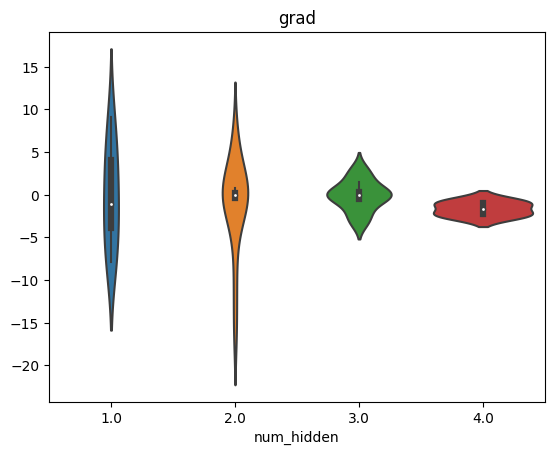

In [26]:
weights_vp(relu_model3, att= 'grad')

能够看出，模型各层仍然处于学习状态，虽然存在梯度不均的状态，但在学习率较小的情况下整体表现仍然较为平稳。不过需要注意的是，对于ReLU激活函数来说，每一层梯度分布的小提琴图会很大程度上受到梯度0值的影响，并且每一次迭代完成后是否取0值都会发生变化，从而影响小提琴图对真实情况反应的准确度。

## 13.4.4 nn.Sequential 快速建模方法及 nn.init 模型参数自定义方法

在讨论如何解决上述激活函数叠加问题之前，我们先补充两个基础工具，其一是使用 nn.Sequntial进行模型的快速构建，其二则是使用 nn.init来进行模型参数修改。其中关于模型参数修改的相关方法，也是支撑本节优化方法实践的核心。

1. nn.Sequential 快速建模方法介绍

在此前的建模环节，我们都是通过完整的创建模型类、通过定义init方法和forward方法来确定模型的基本结构，传播方式和激活函数。除了这种模型定义方法外，PyTorch还支持使用nn.Sequential来快速，在借助nn.Sequential进行模型构建过程中，我们只需要将每一层神经元的连接方法和激活函数作为参数输入 nn.Sequential即可，具体流程如下：

In [27]:
# 设置随机数种子
torch.manual_seed(25)

# 构建上述 LR_ReLU_test模型
relu_test = nn.Sequential(nn.Linear(2, 2, bias= False), nn.ReLU(), nn.Linear(2, 1, bias=False))

在上述模型定义过程中，relu_test相当于实例化之后的模型

In [28]:
list(relu_test.parameters())

[Parameter containing:
 tensor([[ 0.3561, -0.4343],
         [-0.6182,  0.5823]], requires_grad=True),
 Parameter containing:
 tensor([[-0.1658, -0.2843]], requires_grad=True)]

而此时的实例化，是 nn.Sequential 类的实例化，也就是说，通过nn.Sequential的一个实例。

In [29]:
isinstance(relu_test, nn.Sequential)

True

而上述 nn.Sequential 所创建的模型结构，就相当于是两层全连接神经网络，并且隐藏层使用ReLU进行处理。其中需要注意的是， nn.ReLU()单独使用时就相当于ReLU函数，而放在 nn.Sequential中就等价于对某一层的输出结果进行ReLU处理。

In [30]:
r1 = nn.ReLU()

In [31]:
t = torch.tensor([1., -1])
t

tensor([ 1., -1.])

In [32]:
r1(t)

tensor([1., 0.])

In [33]:
torch.relu(t)

tensor([1., 0.])

当然，通过nn.Sequential定义的模型也可以执行向前传播过程

In [34]:
f = torch.tensor([[1, 2.]], requires_grad= True)
f

tensor([[1., 2.]], requires_grad=True)

In [35]:
relu_test.forward(f)

tensor([[-0.1553]], grad_fn=<MmBackward0>)

我们可以手动验证

In [36]:
w1 = list(relu_test.parameters())[0].t()    # 第一层传播参数
w1

tensor([[ 0.3561, -0.6182],
        [-0.4343,  0.5823]], grad_fn=<TBackward0>)

In [37]:
w2 = list(relu_test.parameters())[1].t()    # 第二层传播参数
w2

tensor([[-0.1658],
        [-0.2843]], grad_fn=<TBackward0>)

In [38]:
torch.mm(torch.relu(torch.mm(f, w1)), w2)

tensor([[-0.1553]], grad_fn=<MmBackward0>)

当然，如果进一步将参数手动设置为此前的W1, W2，就可以复现出ReLU激活函数失效的例子。那如何才能修改模型数值呢？

总而言之，我们不难发现，利用nn.Sequential进行模型创建在模型结构相对简单时可以大幅减少代码量，并且模型效果和先通过定义类，再进行实例化的模型效果相同，但该方法在定义高度复杂的模型或者定义更加灵活的模型时就显得力不从心了。

2. 模型参数自定义方法

接下来，继续补充关于手动设置模型参数及模型参数共享的方法。首先，对于模型参数来说，parameters返回结果是个生成器，通过list转化后会生成一个可微张量构成的list。

* 通过修改可微张量方法修改参数

In [39]:
relu_test.parameters()

<generator object Module.parameters at 0x00000232918D85F0>

In [40]:
list(relu_test.parameters())

[Parameter containing:
 tensor([[ 0.3561, -0.4343],
         [-0.6182,  0.5823]], requires_grad=True),
 Parameter containing:
 tensor([[-0.1658, -0.2843]], requires_grad=True)]

In [41]:
list(relu_test.parameters())[0]

Parameter containing:
tensor([[ 0.3561, -0.4343],
        [-0.6182,  0.5823]], requires_grad=True)

因此，我们可以通过修改可微张量数值的方法对其进行修改。在Lesson 12 中，我们介绍了三种修改可微张量数值的方法，这里我们直接使用.data的方法对其进行修改：

In [42]:
# 修改目标
w1 = torch.tensor([[0., 0], [-1, -2]])
w2 = torch.tensor([1., -1]).reshape(-1, 1)
w1

tensor([[ 0.,  0.],
        [-1., -2.]])

In [43]:
w2

tensor([[ 1.],
        [-1.]])

In [44]:
list(relu_test.parameters())[0].data = w1.t()
list(relu_test.parameters())[1].data = w2.t()

In [45]:
# 查看修改结果
list(relu_test.parameters())

[Parameter containing:
 tensor([[ 0., -1.],
         [ 0., -2.]], requires_grad=True),
 Parameter containing:
 tensor([[ 1., -1.]], requires_grad=True)]

然后即可执行向前传播

In [46]:
f = torch.tensor([[1, 2.]])
f

tensor([[1., 2.]])

In [47]:
# 模型输出结果
out = relu_test.forward(f)
out

tensor([[0.]], grad_fn=<MmBackward0>)

In [48]:
# 真实标签
l = torch.tensor([[3. ]])
l

tensor([[3.]])

接下来计算损失函数

In [49]:
loss = F.mse_loss(out, l)
loss

tensor(9., grad_fn=<MseLossBackward0>)

In [50]:
# 进行反向传播
loss.backward()

In [51]:
# 查看模型参数梯度
list(relu_test.parameters())[0].grad

tensor([[0., 0.],
        [0., 0.]])

In [52]:
list(relu_test.parameters())[1].grad

tensor([[0., 0.]])

至此也验证了和此前手动实现的相同结果。

* 使用init方法创建满足某种分布的参数

除了通过手动修改参数值以外，我们还可以使用 nn.init方法来对模型参数进行修改。

In [53]:
# 重新设置初始化模型参数取值
# 设置随机数种子
torch.manual_seed(25)

# 构建上述LR_RELU_Test模型
relu_test = nn.Sequential(nn.Linear(2, 2, bias= False), nn.ReLU(), nn.Linear(2, 1, bias= False))

In [54]:
list(relu_test.parameters())

[Parameter containing:
 tensor([[ 0.3561, -0.4343],
         [-0.6182,  0.5823]], requires_grad=True),
 Parameter containing:
 tensor([[-0.1658, -0.2843]], requires_grad=True)]

(1) nn.init.uniform_ 方法，新生成的参数服从均匀分布

In [55]:
nn.init.uniform_(list(relu_test.parameters())[0], 0, 1)     # 设置参数数值为均匀分布在0， 1区间内的随机数

Parameter containing:
tensor([[0.5933, 0.2911],
        [0.2416, 0.5582]], requires_grad=True)

当然，和此前一样，带有下划线的函数都是能够直接修改对象本身的

In [56]:
list(relu_test.parameters())[0]

Parameter containing:
tensor([[0.5933, 0.2911],
        [0.2416, 0.5582]], requires_grad=True)

(2) nn.init.normal_方法，新生成的参数服从正态分布

In [57]:
nn.init.normal_(list(relu_test.parameters())[0], 0, 1)  # 服从均值为0，标准差为1的正态分布

Parameter containing:
tensor([[-1.3812,  1.2157],
        [ 0.0827,  0.5799]], requires_grad=True)

（3） nn.init.constant_ 方法，新生成的参数为某一常数

In [58]:
nn.init.constant_(list(relu_test.parameters())[0], 1)    # 生成全部参数为1

Parameter containing:
tensor([[1., 1.],
        [1., 1.]], requires_grad=True)

当然，上述过程并不复杂，并且相同的修改目标，使用手动方式也可以实现。对于nn.init方法来说，最核心的使用场景是能够创建服从特殊分布、具备一定特性的，能够辅助模型迭代收敛的初始参数。相关方法我们将在下一小结详细介绍。